In [1]:
#Import important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')


from scipy import stats
from scipy.stats import norm, skew

In [ ]:
#importing the data into dataframes
train_data = pd.read_csv('train_house.csv',low_memory=False)
test_data = pd.read_csv('test_house.csv',low_memory=False)

In [ ]:
train_data.head()

In [ ]:
test_data.info()

## Data Exploration

In [13]:
def wrangle(datapath):
    #read data into dataframe
    df = pd.read_csv(datapath)
    
    #get list of features with above 20% missing values
    mask = df.isna().sum()[df.isna().sum()/len(df) > 0.2].keys().tolist()
    #drop the features above with above 20% missing value
    df.drop(columns=mask,inplace=True)
    

    #trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2"
    low, high = df["MSSubClass"].quantile([0.1, 0.9])
    mask_area = df["MSSubClass"].between(low, high)
    df = df[mask_area] 
    
    #group unique feature values in 3 classes (multicollinerity columns)
    mid_unique_values =[]
    large_unique_values =[]
    target = []
    #concatinating features with mid and low counts of unique values
    for col in df.columns:
        value = df[col].nunique()
        if value < 25:
                mid_unique_values.append(col)
        elif col == "SalePrice":
            target.append(col)
        else:
                large_unique_values.append(col)
               
    data = pd.concat([df[mid_unique_values],df[target]],axis=1)
    return data

In [14]:
train = wrangle('train_house.csv')
test = wrangle('test_house.csv')

In [15]:
train.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,0,0,0,2,2008,WD,Normal,208500
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,Y,0,0,0,5,2007,WD,Normal,181500
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,0,0,0,9,2008,WD,Normal,223500
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,TA,Y,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,TA,Y,0,0,0,12,2008,WD,Normal,250000


In [16]:
test.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCars,GarageQual,GarageCond,PavedDrive,3SsnPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,1.0,TA,TA,Y,0,0,6,2010,WD,Normal
1,20,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,1.0,TA,TA,Y,0,0,6,2010,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,2.0,TA,TA,Y,0,0,3,2010,WD,Normal
3,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,2.0,TA,TA,Y,0,0,6,2010,WD,Normal
4,120,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,2.0,TA,TA,Y,0,0,1,2010,WD,Normal


In [17]:
print(train.shape)
print(train.info())
print(train.columns.nunique())

(1357, 57)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1357 non-null   int64 
 1   MSZoning       1357 non-null   object
 2   Street         1357 non-null   object
 3   LotShape       1357 non-null   object
 4   LandContour    1357 non-null   object
 5   Utilities      1357 non-null   object
 6   LotConfig      1357 non-null   object
 7   LandSlope      1357 non-null   object
 8   Neighborhood   1357 non-null   object
 9   Condition1     1357 non-null   object
 10  Condition2     1357 non-null   object
 11  BldgType       1357 non-null   object
 12  HouseStyle     1357 non-null   object
 13  OverallQual    1357 non-null   int64 
 14  OverallCond    1357 non-null   int64 
 15  RoofStyle      1357 non-null   object
 16  RoofMatl       1357 non-null   object
 17  Exterior1st    1357 non-null   object
 18  Exterior2nd    13

In [18]:
print(test.shape)
print(test.info())
print(test.columns.nunique())

(1355, 55)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1355 non-null   int64  
 1   MSZoning       1351 non-null   object 
 2   Street         1355 non-null   object 
 3   LotShape       1355 non-null   object 
 4   LandContour    1355 non-null   object 
 5   Utilities      1353 non-null   object 
 6   LotConfig      1355 non-null   object 
 7   LandSlope      1355 non-null   object 
 8   Neighborhood   1355 non-null   object 
 9   Condition1     1355 non-null   object 
 10  Condition2     1355 non-null   object 
 11  BldgType       1355 non-null   object 
 12  HouseStyle     1355 non-null   object 
 13  OverallQual    1355 non-null   int64  
 14  OverallCond    1355 non-null   int64  
 15  RoofStyle      1355 non-null   object 
 16  RoofMatl       1355 non-null   object 
 17  Exterior1st    1354 non-null   object 
 1

In [19]:
#recasting float types in test as ints
y_train = train["SalePrice"]
train.drop(columns="SalePrice",inplace=True)

#drop features not common to both train and test datasets
off = []
for col in train.columns:
      if col not in test.columns:
            off.append(col)
train.drop(columns=off,inplace=True)            

In [20]:
#Get cordinality of categorical features and output result as a dataframe for the train data
categorical_data_train = train.select_dtypes(include='object').copy()

count = [len(train[features].unique()) for features in categorical_data_train]
data_tuples = list(zip(categorical_data_train,count))
data = pd.DataFrame(data_tuples, columns=['Features','Number of distinct values'])
data

,Features,Number of distinct values
0,MSZoning,5
1,Street,2
2,LotShape,4
3,LandContour,4
4,Utilities,2
5,LotConfig,5
6,LandSlope,3
7,Neighborhood,23
8,Condition1,9
9,Condition2,7


In [21]:
#mask high cordinality feature in the train dataset (categorical)
large_unique_value_train =[]
for col in categorical_data_train.columns:
    value = len(categorical_data_train[col].unique())
    if value > 5:
        large_unique_value_train.append(col)
print(large_unique_value_train)

['Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageType', 'GarageQual', 'GarageCond', 'SaleType', 'SaleCondition']


In [22]:
#caste of high cordinality features for train dataset
for val in large_unique_value_train:
    top_5_train = train[val].value_counts().head(5)
    train[val] = train[val].apply(lambda c: c if c in top_5_train else "Others")
    

In [23]:
#Get cordinality of numerical features and output result as a dataframe for train data
int_data_train = train.select_dtypes(include='int64').copy()
#for feature in features:
count = [len(train[features].unique()) for features in int_data_train]
data_tuple = list(zip(int_data_train,count))
data = pd.DataFrame(data_tuple, columns=['Features','Number of distinct values'])
data

,Features,Number of distinct values
0,MSSubClass,12
1,OverallQual,10
2,OverallCond,9
3,LowQualFinSF,21
4,BsmtFullBath,4
5,BsmtHalfBath,3
6,FullBath,4
7,HalfBath,3
8,BedroomAbvGr,7
9,KitchenAbvGr,4


In [24]:
#concatinating features with mid and low counts of unique values numerical train data
large_unique_int =[]
for col in int_data_train.columns:
    value = len(int_data_train[col].unique())
    if value > 5:
        large_unique_int.append(col)
print(large_unique_int)

['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BedroomAbvGr', 'TotRmsAbvGrd', '3SsnPorch', 'PoolArea', 'MoSold']


In [25]:
#caste of high cordinality features numerical train data
for val in large_unique_int:
    top_5 = train[val].value_counts().head(5)
    train[val] = train[val].apply(lambda c: c if c in top_5 else 0)

In [26]:
#Get cordinality of numerical features and output result as a dataframe for test data
categorical_data_test = test.select_dtypes(include='object').copy()
#for feature in features:
count = [len(test[features].unique()) for features in categorical_data_test]
data_tuples = list(zip(categorical_data_test,count))
data = pd.DataFrame(data_tuples, columns=['Features','Number of distinct values'])
data

,Features,Number of distinct values
0,MSZoning,6
1,Street,2
2,LotShape,4
3,LandContour,4
4,Utilities,2
5,LotConfig,5
6,LandSlope,3
7,Neighborhood,24
8,Condition1,9
9,Condition2,5


In [27]:
#mask high cordinality feature in the test dataset (categorical)
large_unique_value_test =[]
for col in categorical_data_test.columns:
    value = len(categorical_data_test[col].unique())
    if value > 5:
        large_unique_value_test.append(col)
print(large_unique_value_test)

['MSZoning', 'Neighborhood', 'Condition1', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageType', 'GarageCond', 'SaleType', 'SaleCondition']


In [28]:
#caste of high cordinality features for test dataset
for val in large_unique_value_test:
    top_5_test = test[val].value_counts().head(5)
    test[val] = test[val].apply(lambda c: c if c in top_5_test else "Others")
    

In [29]:
#Get cordinality of numerical features and output result as a dataframe for test data
int_data_test = test.select_dtypes(include='int64').copy()
#for feature in features:
count = [len(test[features].unique()) for features in int_data_test]
data_tuple = list(zip(int_data_test,count))
data = pd.DataFrame(data_tuple, columns=['Features','Number of distinct values'])
data

,Features,Number of distinct values
0,MSSubClass,12
1,OverallQual,10
2,OverallCond,9
3,LowQualFinSF,12
4,FullBath,5
5,HalfBath,3
6,BedroomAbvGr,7
7,KitchenAbvGr,3
8,TotRmsAbvGrd,12
9,Fireplaces,5


In [30]:
#concatinating features with mid and low counts of unique values numerical test data
large_unique_int_test =[]
for col in int_data_test.columns:
    value = len(int_data_test[col].unique())
    if value > 5:
        large_unique_int_test.append(col)
print(large_unique_int_test)

['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BedroomAbvGr', 'TotRmsAbvGrd', '3SsnPorch', 'PoolArea', 'MoSold']


In [31]:
#caste of high cordinality features numerical train data
for val in large_unique_int_test:
    top_5 = test[val].value_counts().head(5)
    test[val] = test[val].apply(lambda c: c if c in top_5 else 0)

In [32]:
#Statistical outlook of the numerical features
train.describe()

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MoSold,YrSold
count,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000
mean,35.644805,5.667649,5.386883,1.587325,0.428150,0.059690,1.563744,0.370671,2.850405,1.036846,5.511422,0.636699,1.792189,1.167281,1.522476,3.892410,2007.819455
std,30.258971,1.849641,1.413141,26.502420,0.519704,0.243144,0.555036,0.501144,0.792960,0.196123,2.248742,0.647147,0.739428,14.431381,28.048427,3.041295,1.322253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000
25%,20.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2007.000000
50%,20.000000,6.000000,5.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,0.000000,0.000000,5.000000,2008.000000
75%,60.000000,7.000000,6.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,0.000000,0.000000,6.000000,2009.000000
max,120.000000,8.000000,8.000000,528.000000,3.000000,2.000000,3.000000,2.000000,5.000000,3.000000,8.000000,3.000000,4.000000,216.000000,555.000000,8.000000,2010.000000


In [33]:
#getting columns with missing values for train dataset
missing_col = train.isna().sum()[train.isna().sum() != 0].index.tolist()

In [34]:
missing_col = test.isna().sum()[test.isna().sum() != 0].index.tolist()

In [36]:
 #fill NAN with mean value.
for col in missing_col:
    train[col] = train[col].fillna(value='mean')
    

In [37]:
#Using label_encoder for all categorical features
train_copy = train.copy()
for c in categorical_data_train:
    label_encoder = LabelEncoder() 
    label_encoder.fit(list(train_copy[c].values)) 
    train_copy[c] = label_encoder.transform(list(train_copy[c].values))
    
train=train_copy.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1459
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1357 non-null   int64
 1   MSZoning       1357 non-null   int32
 2   Street         1357 non-null   int32
 3   LotShape       1357 non-null   int32
 4   LandContour    1357 non-null   int32
 5   Utilities      1357 non-null   int32
 6   LotConfig      1357 non-null   int32
 7   LandSlope      1357 non-null   int32
 8   Neighborhood   1357 non-null   int32
 9   Condition1     1357 non-null   int32
 10  Condition2     1357 non-null   int32
 11  BldgType       1357 non-null   int32
 12  HouseStyle     1357 non-null   int32
 13  OverallQual    1357 non-null   int64
 14  OverallCond    1357 non-null   int64
 15  RoofStyle      1357 non-null   int32
 16  RoofMatl       1357 non-null   int32
 17  Exterior1st    1357 non-null   int32
 18  Exterior2nd    1357 non-null   int32
 19  MasVnr

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1459
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1357 non-null   int64
 1   MSZoning       1357 non-null   int32
 2   Street         1357 non-null   int32
 3   LotShape       1357 non-null   int32
 4   LandContour    1357 non-null   int32
 5   Utilities      1357 non-null   int32
 6   LotConfig      1357 non-null   int32
 7   LandSlope      1357 non-null   int32
 8   Neighborhood   1357 non-null   int32
 9   Condition1     1357 non-null   int32
 10  Condition2     1357 non-null   int32
 11  BldgType       1357 non-null   int32
 12  HouseStyle     1357 non-null   int32
 13  OverallQual    1357 non-null   int64
 14  OverallCond    1357 non-null   int64
 15  RoofStyle      1357 non-null   int32
 16  RoofMatl       1357 non-null   int32
 17  Exterior1st    1357 non-null   int32
 18  Exterior2nd    1357 non-null   int32
 19  MasVnr

In [39]:
#Using label_encoder for all categorical features
test_copy = test.copy()
for c in categorical_data_test:
    label_encoder = LabelEncoder() 
    label_encoder.fit(list(test_copy[c].values)) 
    test_copy[c] = label_encoder.transform(list(test_copy[c].values))
    
test=test_copy.copy().dropna()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1352 non-null   int64  
 1   MSZoning       1352 non-null   int32  
 2   Street         1352 non-null   int32  
 3   LotShape       1352 non-null   int32  
 4   LandContour    1352 non-null   int32  
 5   Utilities      1352 non-null   int32  
 6   LotConfig      1352 non-null   int32  
 7   LandSlope      1352 non-null   int32  
 8   Neighborhood   1352 non-null   int32  
 9   Condition1     1352 non-null   int32  
 10  Condition2     1352 non-null   int32  
 11  BldgType       1352 non-null   int32  
 12  HouseStyle     1352 non-null   int32  
 13  OverallQual    1352 non-null   int64  
 14  OverallCond    1352 non-null   int64  
 15  RoofStyle      1352 non-null   int32  
 16  RoofMatl       1352 non-null   int32  
 17  Exterior1st    1352 non-null   int32  
 18  Exterior

In [40]:
train = clean_train(train)
test = clean_train(test)

In [41]:
# Build Model
model = Ridge()

# Fit model
model.fit(train,y_train)

Ridge()

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1352 non-null   int64  
 1   MSZoning       1352 non-null   int32  
 2   Street         1352 non-null   int32  
 3   LotShape       1352 non-null   int32  
 4   LandContour    1352 non-null   int32  
 5   Utilities      1352 non-null   int32  
 6   LotConfig      1352 non-null   int32  
 7   LandSlope      1352 non-null   int32  
 8   Neighborhood   1352 non-null   int32  
 9   Condition1     1352 non-null   int32  
 10  Condition2     1352 non-null   int32  
 11  BldgType       1352 non-null   int32  
 12  HouseStyle     1352 non-null   int32  
 13  OverallQual    1352 non-null   int64  
 14  OverallCond    1352 non-null   int64  
 15  RoofStyle      1352 non-null   int32  
 16  RoofMatl       1352 non-null   int32  
 17  Exterior1st    1352 non-null   int32  
 18  Exterior

In [43]:
y_test_pred = pd.Series(model.predict(test))
y_test_pred.head()

0     69594.449084
1    126090.603977
2    186653.312969
3    194138.041153
4    156046.527542
dtype: float64

In [44]:
coefficients = model.coef_
features = train.columns
feat_imp = pd.Series(coefficients,index=features).sort_values(key=abs).tail(15)
feat_imp 

RoofStyle        7294.129982
BedroomAbvGr     7890.988281
KitchenAbvGr    -9731.407786
RoofMatl        10339.918016
CentralAir      10807.809300
BsmtQual       -11705.012409
KitchenQual    -13574.770660
Condition2     -14428.652352
Fireplaces      16809.045999
BsmtFullBath    16925.812686
HalfBath        17344.932865
ExterQual      -17716.551842
GarageCars      19296.408044
FullBath        31995.892883
Street          46367.046002
dtype: float64

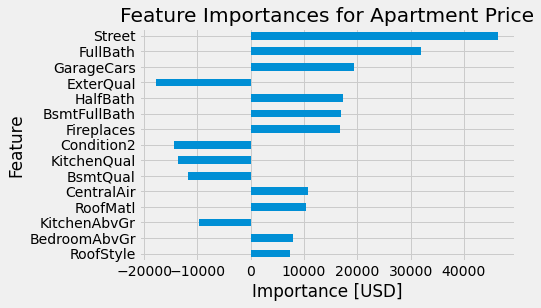

In [45]:
# Build bar chart for the 15 most influential coefficients of the model
feat_imp.plot(kind="barh")
# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price");

In [46]:
#save the model for future use,using pickle
import pickle 

pickle.dump(model, open('model_house.pkl', 'wb'))